##Paraphrasing using T5, finetuned using PAWS dataset

In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 12.4 MB/s 


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [ ]:
model_name= 'Vamsi/T5_Paraphrase_Paws'
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to('cuda')

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [ ]:
paraphrase = 'Why would you like my email address?'

In [ ]:
text = 'paraphrase:' + paraphrase + '</s>'

In [ ]:
encoding = tokenizer.encode_plus(text,pad_to_max_length=True, return_tensors="pt")

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids, attention_masks = encoding["input_ids"].to("cuda"), encoding["attention_mask"].to("cuda")

In [ ]:
outputs = model.generate(
    input_ids=input_ids, attention_mask=attention_masks,
    max_length=256,
    do_sample=True,
    top_k=120,
    top_p=0.95,
    early_stopping=True,
    num_return_sequences=5
)

In [ ]:
for output in outputs:
    line = tokenizer.decode(output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
    print(line)

Why do you want my email address?
Why do you want my email address?
Is it really important to me that you want my email address?
Warum do you want my email address?
Why would you like my email address?


In [ ]:
#running this without the question mark produces slightly different results.

In [ ]:
for output in outputs:
    line = tokenizer.decode(output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
    print(line)

Why would you want to know my email address?
  Why do you want my email address?
Pourquoi do you want my email address?
Why do you want to keep my email address?
Why do you want my email address?


In [ ]:
# starting a chain; input: Why do you want to keep my email address?

In [ ]:
for output in outputs:    
  line = tokenizer.decode(output, skip_special_tokens=True,clean_up_tokenization_spaces=True)    
  print(line)

Why do you want to keep my email address?
Why do you want my email address to stay?
Why do you want to keep my email address?
Why do you want to keep my email address?
Why would you want to keep my email address?


In [ ]:
#Why would you like my email address?
for output in outputs:      
  line = tokenizer.decode(output, skip_special_tokens=True,clean_up_tokenization_spaces=True)      
  print(line)

Why would you like my email address?
Why would you want my email address?
I would like my email address if you liked it more?
Why would you want my email address?
Why would you like my email address?


In [ ]:
# Although the results are not like what one would have expected but still using chain, i.e., the outputs from one
# example answer as input to the next, have generated a few new sentences(at least one sentence for one type of input) 
# with the same intent

## More General version of T-5 finetuned on Quora Question Answer Pairs Dataset. [To DO! Implementation not complete yet]

In [ ]:
!pip install pytorch-lightning

In [ ]:
!pip install streamlit

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
import torch

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import AdamW, T5ForConditionalGeneration, T5Tokenizer, get_linear_schedule_with_warmup

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
class T5FineTuner(pl.LightningModule):

  def __init__(self,hparams):

    # Calling the super constructer
    super(T5FineTuner,self).__init__()

    self.hparams = hparams

    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)


  def forward(self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None):

    return self.model(input_ids, attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            lm_labels=lm_labels,)
    
  def is_logger(self):
      return self.trainer.proc_rank <= 0
    

  def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss

  def training_step(self, batch, batch_idx):
      loss = self._step(batch)

      tensorboard_logs = {"train_loss": loss}
      return {"loss": loss, "log": tensorboard_logs}


  def training_epoch_end(self, outputs):
      avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
      tensorboard_logs = {"avg_train_loss": avg_train_loss}
      return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
      loss = self._step(batch)
      return {"val_loss": loss}

  def validation_epoch_end(self, outputs):
      avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
      tensorboard_logs = {"val_loss": avg_loss}
      return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}


  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]


  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, using_native_amp=None):
    if self.trainer.use_tpu:
        xm.optimizer_step(optimizer)
    else:
        optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()


  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = CustomDataset(tokenizer=self.tokenizer, type_path="PAW_Train_Global",data_dir=self.hparams.data_dir, max_len=self.hparams.max_seq_length)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True,
                            num_workers=4)
    t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = CustomDataset(tokenizer=self.tokenizer, type_path="PAW_Test_Global",data_dir=self.hparams.data_dir, max_len=self.hparams.max_seq_length)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)
  



In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))


In [ ]:
# Hyper parameters
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=6,
    eval_batch_size=6,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, 
    opt_level='O1', 
    max_grad_norm=1.0,
    seed=42,
)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

In [ ]:
if not os.path.exists('t5_QQP'):
    os.makedirs('t5_QQP')


args_dict.update({'output_dir': 't5_paraphrase','num_train_epochs':3,'max_seq_length':256})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': '', 'output_dir': 't5_paraphrase', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 256, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 6, 'eval_batch_size': 6, 'num_train_epochs': 3, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [ ]:
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    callbacks=[LoggingCallback()],
)

In [ ]:
model = T5FineTuner(args)

In [ ]:
# I will have to debug and add a few things before using this model

#CTRL

In [ ]:
from transformers import CTRLModel, CTRLConfig

In [ ]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Thu Oct 28 19:33:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/

In [ ]:
!git clone https://github.com/salesforce/ctrl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning into 'ctrl'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 163 (delta 29), reused 26 (delta 26), pack-reused 128
Receiving objects: 100% (163/163), 24.45 MiB | 25.18 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [ ]:
%cd ctrl/

/content/ctrl


In [ ]:
!git checkout lower_memory

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Branch 'lower_memory' set up to track remote branch 'lower_memory' from 'origin'.
Switched to a new branch 'lower_memory'


In [ ]:
!pip2 install tensorflow-gpu==1.14

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 377.0MB 41kB/s 
     |████████████████████████████████| 3.2MB 31.3MB/s 
     |████████████████████████████████| 491kB 32.8MB/s 
ERROR: tensorflow 2.1.0 has requirement tensorboard<2.2.0,>=2.1.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 2.1.0 has requirement tensorflow-estimator<2.2.0,>=2.1.0rc0, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
  Found existing installation: tensorboard 2.1.0
    Uninstalling tensorboard-2.1.0:
      Successfully uninstalled tensorboard-2.1.0
  Found existing installation: tensorflow-estimator 1.15.0
    Uninstalling tensorflow-estimator-1.15.0

In [ ]:
!patch -b /usr/local/lib/python2.7/dist-packages/tensorflow_estimator/python/estimator/keras.py estimator.patch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
patching file /usr/local/lib/python2.7/dist-packages/tensorflow_estimator/python/estimator/keras.py


In [ ]:
!pip2 install fastBPE

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp27-cp27mu-linux_x86_64.whl size=476455 sha256=fbcb8243b4f282841b35230fc42ce972c46c7da3b40fe04f67ae1ba5d6be3dc6
  Stored in directory: /root/.cache/pip/wheels/f3/0c/9c/fc62058b4d473a5602bcd3d3edfece796f123875379ea82d79
Successfully built fastBPE


In [ ]:
!pip2 install gsutil

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 2.9MB 5.3MB/s 
     |████████████████████████████████| 174kB 42.7MB/s 
     |████████████████████████████████| 276kB 30.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61kB 6.9MB/s 
ERROR: Could not find a version that satisfies the requirement rsa==4.7.2 (from gcs-oauth2-boto-plugin>=2.7->gsutil) (from versions: 1.1, 1.2, 1.3, 1.3.1, 1.3.2, 1.3.3, 3.0, 3.0.1, 3.1, 3.1.1, 3.1.2, 3.1.4, 3.2, 3.2.2, 3.2.3, 3.3, 3.4, 3.4.1, 3.4.2, 4.0, 4.1.1, 4.2, 4.3, 4.4, 4.5, 4.7.1)
ERROR: No matching distribution found fo

In [ ]:
!gsutil -m cp -r gs://sf-ctrl/seqlen256_v1.ckpt .

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Copying gs://sf-ctrl/seqlen256_v1.ckpt/checkpoint...
Copying gs://sf-ctrl/seqlen256_v1.ckpt/model.ckpt-413000.index...
Copying gs://sf-ctrl/seqlen256_v1.ckpt/model.ckpt-413000.data-00000-of-00001...
Copying gs://sf-ctrl/seqlen256_v1.ckpt/model.ckpt-413000.meta...
\ [4/4 files][ 12.7 GiB/ 12.7 GiB] 100% Done  46.2 MiB/s ETA 00:00:00           
Operation completed over 4 objects/12.7 GiB.                                     


In [ ]:
!python2 generation.py --model seqlen256_v1.ckpt/model.ckpt-413000.data-00000-of-00001 --print_once

Streaming output truncated to the last 5000 lines.
2
3
4
5
6
7
168
2
3
4
5
6
7
169
2
3
4
5
6
7
170
2
3
4
5
6
7
171
2
3
4
5
6
7
172
2
3
4
5
6
7
173
2
3
4
5
6
7
174
2
3
4
5
6
7
175
2
3
4
5
6
7
176
2
3
4
5
6
7
177
2
3
4
5
6
7
178
2
3
4
5
6
7
179
2
3
4
5
6
7
180
2
3
4
5
6
7
181
2
3
4
5
6
7
182
2
3
4
5
6
7
183
2
3
4
5
6
7
184
2
3
4
5
6
7
185
2
3
4
5
6
7
186
2
3
4
5
6
7
187
2
3
4
5
6
7
188
2
3
4
5
6
7
189
2
3
4
5
6
7
190
2
3
4
5
6
7
191
2
3
4
5
6
7
192
2
3
4
5
6
7
193
2
3
4
5
6
7
194
2
3
4
5
6
7
195
2
3
4
5
6
7
196
2
3
4
5
6
7
197
2
3
4
5
6
7
198
2
3
4
5
6
7
199
2
3
4
5
6
7
200
2
3
4
5
6
7
201
2
3
4
5
6
7
202
2
3
4
5
6
7
203
2
3
4
5
6
7
204
2
3
4
5
6
7
205
2
3
4
5
6
7
206
2
3
4
5
6
7
207
2
3
4
5
6
7
208
2
3
4
5
6
7
209
2
3
4
5
6
7
210
2
3
4
5
6
7
211
2
3
4
5
6
7
212
2
3
4
5
6
7
213
2
3
4
5
6
7
214
2
3
4
5
6
7
215
2
3
4
5
6
7
216
2
3
4
5
6
7
217
2
3
4
5
6
7
218
2
3
4
5
6
7
219
2
3
4
5
6
7
220
2
3
4
5
6
7
221
2
3
4
5
6
7
222
2
3
4
5
6
7
223
2
3
4
5
6
7
224
2
3
4
5
6
7
225
2
3
4
5
6
7
226
2
3
4

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Key to Text

In [ ]:
!pip install keytotext --upgrade

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 290 kB 48.1 MB/s 
     |████████████████████████████████| 243 kB 43.4 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 139 kB 45.5 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=691dc8ea63a469629da36385ea8619cc28c2abb1442c2c4eee152f078a894eae
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=959ba31c2881d8c86c4f8a568a36abd

In [ ]:
from keytotext import pipeline

Global seed set to 42


In [ ]:
nlp = pipeline("k2t")

In [ ]:
nlp

In [ ]:
nlp(['why','you','want','my','email','address'])

'I| Have a job.'

In [ ]:
nlp = pipeline("mrm8488/t5-base-finetuned-common_gen")

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
nlp(['why','do','you','want','my','email'])

'why do you want me to send you an email'

In [ ]:
nlp(['why','want','my','email'])

'why do i want to send you an email'

In [ ]:
nlp(['why','you','want','my','email'])

'i want to know why you want this email.'

In [ ]:
# if we further extend this model to include the questions as well, this
# can generate pretty good results

# Pegasus

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

In [ ]:
model_name = 'tuner007/pegasus_paraphrase'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install sentencepiece

In [ ]:
tokenizer = PegasusTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

In [ ]:
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

In [ ]:
def get_response(input_text,num_return_sequences,num_beams,temperature=1.5):
  batch = tokenizer([input_text],truncation=True,padding='longest',max_length=60, return_tensors="pt").to(torch_device)
  translated = model.generate(**batch,max_length=60,num_beams=num_beams, 
                              num_return_sequences=num_return_sequences, temperature=temperature)
  tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
  return tgt_text

In [ ]:
get_response('Why do you want my email address',10,10)

["I don't understand why you want my email address.",
 'Why do you want my email address?',
 'Why would you want my email address?',
 "I don't know why you want my email address.",
 'Why do you need my email address?',
 "I don't understand why you would want my email address.",
 'You want my email address?',
 'Why do you want me to have an email address?',
 'Why do you want that email address?',
 'You want my email address.']

In [ ]:
# let's decrease the temperature
get_response('Why do you want my email address',10,10,0.1)

["I don't understand why you want my email address.",
 'Why do you want my email address?',
 'Why would you want my email address?',
 "I don't know why you want my email address.",
 'Why do you need my email address?',
 "I don't understand why you would want my email address.",
 'You want my email address?',
 'Why do you want me to have an email address?',
 'Why do you want that email address?',
 'You want my email address.']

In [ ]:
# let's increase the temperature
get_response('Why do you want my email address',10,10,3.0)

["I don't understand why you want my email address.",
 'Why do you want my email address?',
 'Why would you want my email address?',
 "I don't know why you want my email address.",
 'Why do you need my email address?',
 "I don't understand why you would want my email address.",
 'You want my email address?',
 'Why do you want me to have an email address?',
 'Why do you want that email address?',
 'You want my email address.']

In [ ]:
# temperature is not affecting the output as seen above

In [ ]:
# let's increase the beam length
get_response('Why do you want my email address',10,100)

["I don't understand why you want my email address.",
 'Why do you want my email address?',
 'Why would you want my email address?',
 "I don't know why you want my email address.",
 'Why do you need my email address?',
 "I don't understand why you would want my email address.",
 'Why should I have an email address?',
 'You want my email address?',
 'Why should I have my email address?',
 'Why do you want me to have an email address?']

In [ ]:
# increasing beam length in this case
# will only yield good results when the sequences returned are pretty close to the beam length

In [ ]:
get_response('Why do you want my email address?',50,50)

['Why do you want my email address?',
 'Why would you want my email address?',
 'Why should I have an email address?',
 "I don't understand why you want my email address.",
 'Why do you need my email address?',
 "I don't know why you want my email address.",
 'Why do you want me to have an email address?',
 'Is it because you want my email address?',
 'Why should I have my email address?',
 'What is the reason you want my email address?',
 'Why did you want my email address?',
 'Why do you want to communicate with me?',
 'Why should I use my email address?',
 "I don't understand why you would want my email address.",
 'Why do you want my email?',
 'Why would you want me to have an email address?',
 'Why do you need an email address?',
 "What's the reason you want my email address?",
 'How come you want my email address?',
 'Why do you want an email address?',
 'What is the reason why you want my email address?',
 'Why do you want my phone number?',
 'Why do you want me to use that emai

In [ ]:
# staring a chain or a tree
get_response("I don't understand why you want my email address",10,10)

["I don't understand why you want my email address.",
 "I'm not sure why you want my email address.",
 "I can't understand why you want my email address.",
 "I don't understand why you would want my email address.",
 "I don't understand why you need my email address.",
 'I am not sure why you want my email address.',
 "I don't understand why you want me to have an email address.",
 "You want my email address, I don't understand it.",
 "I don't understand why you want my email.",
 "You want my email address, I don't understand."]

In [ ]:
get_response("I am not sure why you want my email address",10,10)

["I don't know why you want my email address.",
 "I don't understand why you want my email address.",
 "I'm not sure why you want my email address.",
 "I don't know why you would want my email address.",
 "I don't understand why you would want my email address.",
 "I don't know why you need my email address.",
 "I don't know why you want me to have an email address.",
 'I have no idea why you want my email address.',
 "I'm not sure why you would want my email address.",
 "I don't know why you want my email."]

In [ ]:
get_response("Why is my email address important to you",10,10)

['Why is my email address important to you?',
 'My email address is important to you.',
 'Is my email address important to you?',
 'Why is my email address important to me?',
 'Why does my email address matter to you?',
 'The email address is important to me.',
 'My email address is important to me.',
 'Why is my email address important?',
 'Why is my email address important to you.',
 'Why is my address important to you?']

In [ ]:
# like this, we can generate a lot of paraphrased sentences. This process of creating chains can be 
# automated. I have done it manually, just for demonstration.

# Parrot

In [ ]:
!pip install parrot

In [ ]:
!pip install git+https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git

In [ ]:
from parrot import Parrot
import torch
import warnings
warnings.filterwarnings("ignore")

In [ ]:
parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5", use_gpu=False)

In [ ]:
phrase = 'Why do you want my email address?'
para_phrases = parrot.augment(input_phrase=phrase, 
                               diversity_ranker="levenshtein",
                               do_diverse=True, 
                               max_return_phrases = 10, 
                               max_length=32, 
                               adequacy_threshold = 0.99, 
                               fluency_threshold = 0.90)

In [ ]:
for para_phrase in para_phrases:
   print(para_phrase)

('i want my email address why do you want it?', 34)
('why do you want to know my email?', 27)
('why do you want my email?', 20)
('why do you want to know my email address?', 20)
('why do people want my email address?', 17)
('why do you need my email address?', 16)
('why do you want my email address?', 12)


In [ ]:
# setting the diversity to false.
# for example

para_phrases = parrot.augment(input_phrase=phrase, 
                               diversity_ranker="levenshtein",
                               do_diverse=False, 
                               max_return_phrases = 10, 
                               max_length=32, 
                               adequacy_threshold = 0.99, 
                               fluency_threshold = 0.90)

for para_phrase in para_phrases:
   print(para_phrase)

('why do people ask for my email address?', 23)
('why do you want to know my email address?', 20)
('why do you want my e-mail address?', 13)
('why do you want my email address?', 12)


In [ ]:
# decreasing the fluency and adequecy

para_phrases = parrot.augment(input_phrase=phrase, 
                               diversity_ranker="levenshtein",
                               do_diverse=True, 
                               max_return_phrases = 10, 
                               max_length=64, 
                               adequacy_threshold = 0.70, 
                               fluency_threshold = 0.75)

for para_phrase in para_phrases:
   print(para_phrase)

('i want my email address why do you want it?', 34)
('i want my email address why do you want my email?', 27)
('why do you want to know my email?', 27)
('why do you want my email?', 20)
('why do you want to know my email address?', 20)
('i want my email address why do you want my email address?', 19)
('why do people want my email address?', 17)
('why do you need my email address?', 16)
('why do you want my email address?', 12)


In [ ]:
# Decreasing fluency and adequecy don't produce any good results.
# It is clear from the name of parameters as well. So, to have good results, it might be better to set a good fluency
# so that the parapharase makes sense, and also the adequecy to force the model to stick to the original intent

# Pegasus & Parrot (Functional Implementation)

### Pegasus

In [ ]:
!pip install transformers
!pip install sentencepiece

In [ ]:
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import math
import pandas as pd

In [ ]:
model_name = 'tuner007/pegasus_paraphrase'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer_pegasus = PegasusTokenizer.from_pretrained(model_name)
model_pegasus = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

#### Functions to create Chain and get Reponse

In [ ]:

# Using recursion to implement chaining. Creating a Breadth-First tree-like structure.

def chain(sentence, hyperParameters, num, default, paraphrased, stack):
    if len(paraphrased)<num:
      batch = tokenizer_pegasus([sentence],truncation=True,padding='longest',max_length=60, return_tensors="pt").to(torch_device)

      translated = model_pegasus.generate(**batch,max_length=60,num_beams=hyperParameters['num_beams'], 
                                      num_return_sequences=default, temperature=hyperParameters['temperature'])
      tgt_text = tokenizer_pegasus.batch_decode(translated, skip_special_tokens=True)

      for sentence in tgt_text:
          if sentence not in paraphrased:
            paraphrased.append(sentence)
    if(len(paraphrased)<num):
      for sentence in paraphrased:
        if(sentence not in stack):
          stack.append(sentence)
          chain(sentence, hyperParameters, num, default, paraphrased, stack)


def get_response(sentences,hyperParameters,chaining, num_phrases):
  '''
  Parameters:-
    sentences: list of tuples. [(sentence, intent),....]
    hyperParameters: Dictionary of hyper-parameters. {num_beams, temperature}
    chaining: Boolean specifying whether to use chaining or not.
    num_phrases: integer number specifying the number of phrases to generate for each input sentence. 4
  '''
  output = []
  for (sentence,intent) in sentences:
    print(sentence)
    paraphrased = [] # To store the paraphrased sentences
    if(chaining):
      num = num_phrases
      default = min(5, num_phrases); # Default number of phrases for each output call
      hyperParameters['num_beams'] = default # as beam length should be equal or greater than
      stack = []                             # number of sequences(default) 
      # Implemented chain using recursion
      chain(sentence,hyperParameters,num,default,paraphrased,stack)
      paraphrased = paraphrased[:num_phrases]

    else:
      batch = tokenizer_pegasus([sentence],truncation=True,padding='longest',max_length=60, return_tensors="pt").to(torch_device)
      translated = model_pegasus.generate(**batch,max_length=60,num_beams=hyperParameters['num_beams'], 
                                  num_return_sequences=num_phrases, temperature=hyperParameters['temperature'])     
      paraphrased += tokenizer_pegasus.batch_decode(translated, skip_special_tokens=True)
    
    output.append((paraphrased,intent))

  return output

#### Function to save the data as a CSV

In [ ]:
def createCSV(paraphrases_list, path, name_of_the_file):
  '''
  Parameters:-
    paraphrases_list: output of the get_response function
    path: path where the csv file should be stored
    name_of_the_file: name  of the output csv file

  '''
  data = {'sentences':[],'labels':[]}
  for paraphrased_type in paraphrases_list:
    rows_para = paraphrased_type[0]
    rows_type = paraphrased_type[1]
    data['sentences'] += rows_para
    data['labels'] += [rows_type]*len(paraphrased_type[0])

  dataFrame = pd.DataFrame(data, columns=['sentences','labels'])
  dataFrame.to_csv(path+'/'+name_of_the_file)
  return dataFrame


#### Hyper-Parameters Explanation

**About Pegasus:-**
Pegasus was originally trained for Abstractive Summarization. During pre-training, instead of predicting masked words or tokens, the model was presented with the challenge to predict the masked sentences. This way, it differes from other Transformer models because Pegasus was pretrained using sentence masking rather than words. Pegasus is based on a transformer encoder-decoder model.

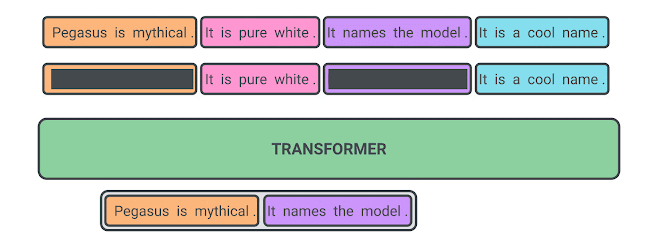


-------------------------------------------------------------
**Hyper-parameters:-**

**->Temperature:** Same as explained in DialoGPT. 

For reference: Temperature sampling is implemented by dividing logits by the temperature value before feeding them into softmax. Temperature greater than 1 generally decreases the confidence while lower temperature makes the model increasingly confident in its top choices. Therefore, we have to find a balance for the value of temperature. If we decrease the temperature too much, the model will become too confident in its top choices and will result in genetating the same answer again and again. On the other hand, if we increase the temperature too much, it will start diverting from the original intent. A value of `1.5` was wound to be perfect for our case (The value was choosen after testing multiple values.)

**!!Note:** For pegasus, changing the temperature didn't seem to make any difference. I tried many values of temperature and generated 100 sentences for each value of temperature (without chaining) but it wasn't even able to generate 5 unique sentences (sentences that are not contained in the output for some other temperature value). Every temperature value generated almost the same sentences.

--------------------------------------------------------------
**-> num_beams**: A parameter for beam search decoder.The beam search algorithm selects multiple alternatives for an input sequence at each timestep based on conditional probability. The number of multiple alternatives depends on a parameter called Beam Width B or `num_beams` in this case. At each time step, the beam search selects B number of best alternatives with the highest probability as the most likely possible choices for the time step.

#### Testing

Define the parameters here.

In [ ]:
sentences = [('Why do you want my email address?','user_asks_why'),
             ('my email address is james@gmail.com','user_provides_email')]

chaining = False
num_phrases = 100  # Number of phrases to be generated for each input sentence
                   # Note, num phrases should be equal or less than the beam length when chain == false

# Define the hyperparameters
hyperParameters = {'num_beams':100,'temperature':1.5}

# Path where the csv file will be stored
path = '/content'

# Name of the csv file
name_of_the_file = 'paraphrased_sentences_pegasus.csv'

!! Execute the below cell to generate responses and then save them in a csv file.

In [ ]:
out = createCSV(get_response(sentences,hyperParameters,chaining, num_phrases),
                path,name_of_the_file)

Why do you want my email address?
my email address is james@gmail.com


In [ ]:
# Kindly, Ignore this cell
sentences = [('Do you mind providing your email address?','user_confirms_if')]
get_response(sentences,hyperParameters,chaining, num_phrases)

Do you mind providing your email address?


[(['Do you want to provide your email address?',
   'Do you want to give your email address?',
   'Are you willing to give your email address?',
   'Are you willing to provide your email address?',
   'Do you want to provide an email address?',
   'Do you want to send an email?',
   'Do you want your email address to be public?',
   'Do you want to use your email address?',
   'Do you have an email address?',
   'Is it okay to give your email address?'],
  'user_confirms_if')]

In [ ]:
# with Chaining
chaining = True
name_of_the_file = 'paraphrased_sentences_pegasus_2.csv'

In [ ]:
out = createCSV(get_response(sentences,hyperParameters,chaining, num_phrases),
                path,name_of_the_file)

Why do you want my email address?
my email address is james@gmail.com


In [ ]:
out

,sentences,labels
0,Why do you want my email address?,user_asks_why
1,Why would you want my email address?,user_asks_why
2,Why do you need my email address?,user_asks_why
3,Why do you want me to have an email address?,user_asks_why
4,Why do you want my email?,user_asks_why
5,I don't understand why you would want my email...,user_asks_why
6,Why would you want to communicate with me?,user_asks_why
7,Why would you want me to have an email address?,user_asks_why
8,I don't understand why you need my email address.,user_asks_why
9,Why do I need an email address?,user_asks_why


### Parrot

In [ ]:
!pip install parrot
!pip install git+https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git

In [ ]:
from parrot import Parrot
import torch
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

In [ ]:
parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5", use_gpu=False)

#### Functions to create Chain and get Reponse

In [ ]:

# Using recursion to implement chaining. Creating a Breadth First tree like structure.

def chain_p(sentence, hyperParameters, num, default, paraphrased, stack):
    if len(paraphrased)<num:
       para_phrases_t = []
       para_phrases  = parrot.augment(input_phrase=sentence, 
                          diversity_ranker="levenshtein",
                          do_diverse=hyperParameters['do_diverse'], 
                          max_return_phrases = default, 
                          max_length=32, 
                          adequacy_threshold = hyperParameters['adequacy_threshold'], 
                          fluency_threshold = hyperParameters['fluency_threshold'])
       para_phrases_t += [para_phrase[0] for para_phrase in para_phrases]
       for sentence in para_phrases_t:
          if sentence not in paraphrased:
            paraphrased.append(sentence)
    if(len(paraphrased)<num):
      for sentence in paraphrased:
        if(sentence not in stack):
          stack.append(sentence)
          chain_p(sentence, hyperParameters, num, default, paraphrased, stack)
          

def get_response_p(sentences,hyperParameters,chaining, num_phrases):
  '''
  Parameters:-
    sentences: list of tuples. [(sentence, intent),....]
    hyperParameters: Dictionary of hyper-parameters. {num_beams, temperature}
    chaining: Boolean specifying whether to use chaining or not.
    num_phrases: integer number specifying the number of phrases to generate for each input sentence. 4
  '''
  output = []
  for (sentence,intent) in sentences:
    print(sentence)
    paraphrased = [] # To store the paraphrased sentences
    if(chaining):
      num = num_phrases
      default = min(5, num_phrases); # Default number of phrases
      stack = []
      # Implemented chain using recursion
      chain_p(sentence,hyperParameters,num,default,paraphrased,stack)
      paraphrased = paraphrased[:num_phrases]

    else:
      para_phrases = parrot.augment(input_phrase=sentence, 
                               diversity_ranker="levenshtein",
                               do_diverse=hyperParameters['do_diverse'], 
                               max_return_phrases = num_phrases, 
                               max_length=32, 
                               adequacy_threshold = hyperParameters['adequacy_threshold'], 
                               fluency_threshold = hyperParameters['fluency_threshold'])
      
      paraphrased += [para_phrase[0] for para_phrase in para_phrases] 

   
    output.append((paraphrased,intent))

  return output

#### Function to Store the data as a CSV



In [ ]:
# same createCSV function
def createCSV(paraphrases_list, path, name_of_the_file):
  '''
  Parameters:-
    paraphrases_list: output of the get_response function
    path: path where the csv file should be stored
    name_of_the_file: name  of the output csv file

  '''
  data = {'sentences':[],'labels':[]}
  for paraphrased_type in paraphrases_list:
    rows_para = paraphrased_type[0]
    rows_type = paraphrased_type[1]
    data['sentences'] += rows_para
    data['labels'] += [rows_type]*len(paraphrased_type[0])

  dataFrame = pd.DataFrame(data, columns=['sentences','labels'])
  dataFrame.to_csv(path+'/'+name_of_the_file)
  return dataFrame


#### Hyper-Parameters Explanation

**About Parrot:-**

Parrot is a paraphrase based utterance augmentation framework. Under the hood, parrot uses the same T-5 model developed by Google. T-5 model was finetuned to generate paraphrases by also including adequecy and fluency thresholds. It proposes that a good paraphrase should be `adequate` and `fluent` while being as different as possible on the surface lexical form. 

With respect to this definition, the 3 key metrics that measures the quality of paraphrases are:

- Adequacy (Is the meaning preserved adequately?)
- Fluency (Is the paraphrase fluent English?)
- Diversity (Lexical / Phrasal / Syntactical) (How much has the paraphrase changed the original sentence?) 

The main aim was to use this model for augmenting data to train NLU based models.

--------------------------------------------------------------
(I had to go into the code to extract the below info because on the GitHub Readme, they don't provide any info about how these hyper-parameters actually work)

**Hyper-Parameters:**

**-> do_diverse:** How much has the paraphrase changed the original sentence? If true, the parrot model will try to create diverse sentences and will try to change the lexical, phrasal and syntactical form of the original sentence but will keep the original intent. There are three diversity rankers the model is using, `levenshtein`, `euclidean`, and `diff`. `levenshtein` works best for every case.

--------------------------------------------------------------
**-> adequacy_threshold**: Is the meaning preserved adequately? As the name suggests, when the value of `adequacy_threshold` is high, the model will be forced to stick to the original intent. If the value is too low, the model will start diverting and the paraphrased sentences won't preserve the original intent of the sentence.

It uses `BART` under the hood to measure the intent similarity between the input sentence and the paraphrased sentence.

--------------------------------------------------------------
**->fluency_threshold:** Is the paraphrase fluent English? As the name suggests, high `fluency_threshold` value will result in more fluent paraphrased sentences. It will make sure that the paraphrased sentence, the model generates, is fluent and doesn't contain any grammatical mistakes.

It uses a simple `BERT` model fine-tuned for fluency score generation to automatically discard the sentences that produces less fluency score than the set threshold.



#### Test

Define and Initialize the parameters here.

In [ ]:
sentences = [('Why do you want my email address?','user_asks_why'),
             ('my email address is james@gmail.com','user_provides_email')]

chaining = False
num_phrases = 10  # Number of phrases to be generated for each input sentence

# Define the hyperparameters
hyperParameters = {'do_diverse':True,'adequacy_threshold':0.99,'fluency_threshold':0.90}

# Diversity Rankers are "levenshtein", "euclidean", "diff"

# Path where the csv file will be stored
path = '/content'

# Name of the csv file
name_of_the_file = 'paraphrased_sentences_parrot.csv'

In [ ]:
# Testing without saving the output in csv, scroll to the end for that prompt.
get_response_p(sentences,hyperParameters,chaining, num_phrases)

In [ ]:
# With Chaining
chaining = True
get_response_p(sentences,hyperParameters,chaining, num_phrases)

Why do you want my email address?
my email address is james@gmail.com


[(['why do people ask for my email address?',
   'do you want my email address?',
   'why do you want my email address?',
   'why does someone want to know my email address?',
   'why are some people asking me for my email address?',
   'why do people ask me for my email address?',
   "i'm interested in your email address",
   'you want my email address?',
   'do you want my email address? why?',
   'why did you ask for my email address?'],
  'user_asks_why'),
 (['my email address is jamesgmailcom'], 'user_provides_email')]

In [ ]:
# As you can see that parrot model is less powerful than the pegasus model
# Parrot was not even able to generate 10 paraphrased sentences for the first sentence
# But with chaining we were able to generate 10

# For the second sentence parrot was only able to generate one paraphrased sentence,
# chaining also didn't wokr for this case

In [ ]:
# To store in a CSV
out = createCSV(get_response_p(sentences,hyperParameters,chaining, num_phrases),
                path,name_of_the_file)

Why do you want my email address?
my email address is james@gmail.com
